# Second generation microstructural features

## Introduction
> **Underlying Literature**: The following module was inspired by the ideas put forward in Chapter 19, Section 4 of [Advances in Financial Machine Learning](https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086) by Marcos Lopez de Prado

In this notebook, we showcase how to properly use the functions belonging to the Second Generation Models of our Microstructural Features module. Second generation place emphasis on  illiquidity to measure market depth.

The second generation of models came after volume datasets started to become available,
and researchers shifted their attention to study the impact that volume has on prices.
More spefically the models foucs on understanding and measuring illiquidity. Illiquidity isan important informative feature in financial ML models, because it is a risk that has an associated premium. These models have a stronger theoretical foundation than first-generation models, in that they explain trading as the strategic interaction between informed and uninformed traders. In doing so, they pay attention to signed volume and order flow imbalance. Most of these features are estimated through regressions. The following models are presented in this notebook:

### Table of Contents
- [Kyle's Lambda](#kyle)
- [Amihud's Lambda](#ami)
- [Hasbrouck's Lambda](#hasb)


<div class="alert alert-block alert-warning">
    
<b>Note:</b> To re-run this Notebook one needs a S&P500 Emini futures contracts dataset that is not included in the repositry. It can be purchased from TickData LLC. Please check [our documentation](https://mlfinlab.readthedocs.io/en/latest/getting_started/barriers_to_entry.html) for more details.

</div>

In [14]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import MlFinLab tools
from mlfinlab.data_structures.standard_data_structures import get_dollar_bars
from mlfinlab.microstructural_features import first_generation
from mlfinlab.microstructural_features import second_generation

In [15]:
# Reading in the tick data
# The datasset is from the S&P500 Emini futures contracts.
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/tick_data.csv"
tick_data = pd.read_csv(url, nrows = 1000)
tick_data["Date and Time"] = tick_data["Date"] + tick_data["Time"]
del tick_data["Date"]
del tick_data["Time"]
tick_data.set_index("Date and Time", inplace=True)

# Previewing the data
tick_data.head()

# Processing data to distinct timestamps to make labels more informative
tick_data_agg = tick_data.groupby('Date and Time').agg({'Price' : 'min', 'Volume': 'sum'})
tick_prices = tick_data_agg['Price']

In [16]:
tick_data_agg

,Price,Volume
Date and Time,,
2023-03-0117:00:00.083,804.25,59
2023-03-0117:00:00.101,804.00,1384
2023-03-0117:00:00.107,804.00,5
2023-03-0117:00:00.112,804.00,1
2023-03-0117:00:00.121,804.00,1
...,...,...
2023-03-0117:01:19.821,803.75,1
2023-03-0117:01:20.789,803.75,1
2023-03-0117:01:20.864,803.75,1


## Kyle's Lambda<a class="anchor" id="kyle"></a>

Kyle's lambda is a measure of market impact cost from Kyle (1985), which can be interpreted as the cost of demanding a certain amount of liquidity over a given time period.

It is also used as a measure of market liquidity and can be estimated by the volume required to move the price of a security by one dollar. This measure is an inverse proxy of liquidity, with higher values of lambda implying lower liquidity and market depth. The authors estimate this measure on a daily basis by using all transactions during normal trading hours on each day.


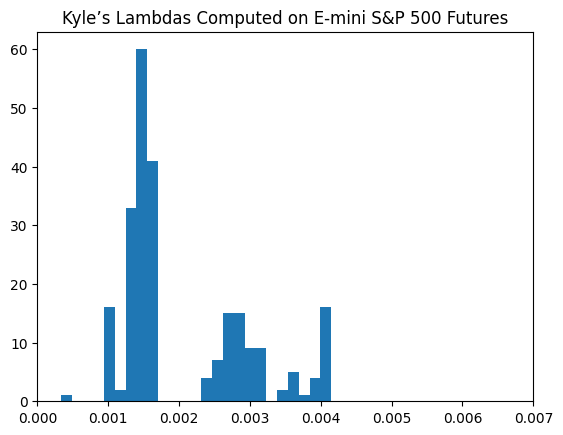

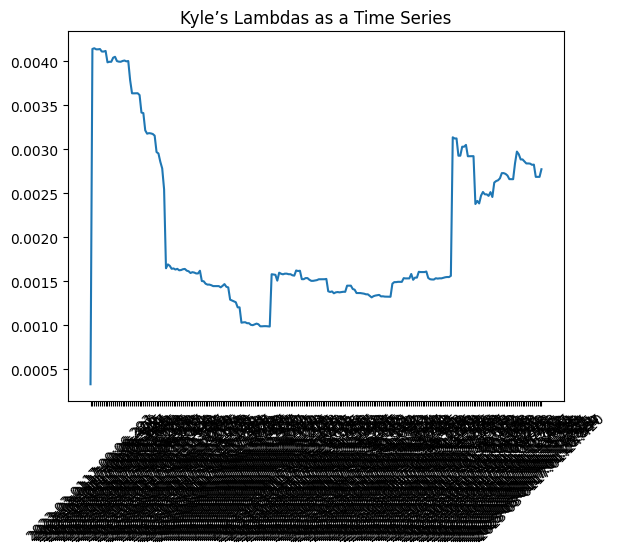

In [17]:
# Need to find the aggresor labels first - Use Tick Rule
tick_classifications = first_generation.tick_rule(prices = tick_prices)

# Calculate Kyle's Lambda
kyles_lambda = second_generation.get_bar_based_kyle_lambda(tick_prices,tick_data_agg['Volume'],
                                                           tick_classifications,window=100)

# Plot Kyle's Lambda
plt.figure(1);
plt.hist(kyles_lambda['kyle_lambda'],bins=25);
plt.xlim(0,0.007);
plt.title('Kyle’s Lambdas Computed on E-mini S&P 500 Futures');
plt.figure(2);
plt.plot(kyles_lambda['kyle_lambda']);
plt.title('Kyle’s Lambdas as a Time Series');
plt.xticks(rotation = 45);

The histogram above displays similar results for Figure 19.3 from de Prado's book. The results slighty differ as we used a different sample period. From this histrogram we can see what are typical vaues for Kyle's lambda and the frequency at which they occur. We also can also plot Kyle's lambda and see where the values spike. On these times the illiquidity for the future is high and the future has a low market depth.

## Amihud's Lambda<a class="anchor" id="ami"></a>

Amihud (2002) studies the positive relationship between absolute returns and illiquidity. In particular, he computes the daily price response associated with one dollar
of trading volume, and argues its value is a proxy of price impact.

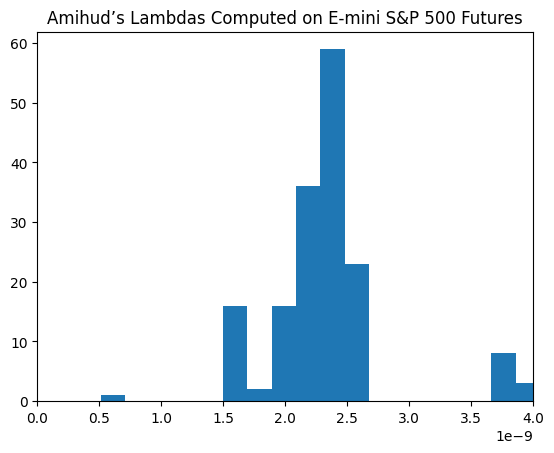

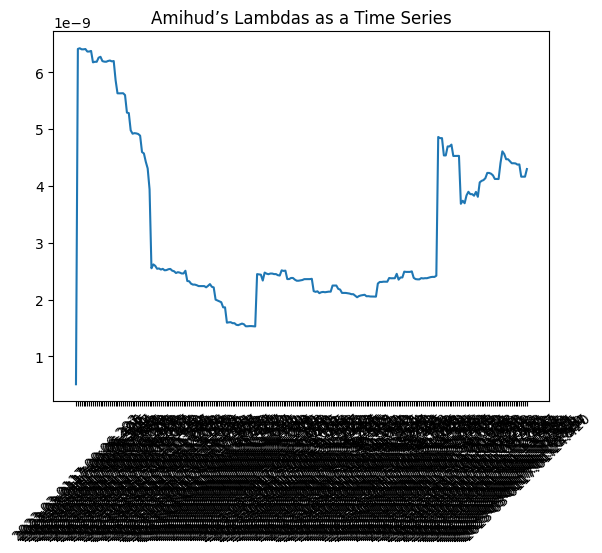

In [18]:
dollar_volumes = tick_data_agg['Price']*tick_data_agg['Volume']

amihud_lambda = second_generation.get_bar_based_amihud_lambda(tick_prices,
                                                             dollar_volumes,window =100)
plt.figure(1);
plt.hist(amihud_lambda['amihud_lambda'],bins=30);
plt.xlim(0,0.000000004);
plt.title('Amihud’s Lambdas Computed on E-mini S&P 500 Futures');
plt.figure(2);
plt.plot(amihud_lambda['amihud_lambda']);
plt.title('Amihud’s Lambdas as a Time Series');
plt.xticks(rotation = 45);

The histogram above displays similar results for Figure 19.4 from de Prado's book. From this histrogram we can see what are typical vaues for Amihud's lambda and the frequency that they occur. Comparing the time series plot of Amihud's lambda to Kyle's lambda we see that they are excatly the same plot wih only differennt values for the lambdas.

## Hasbrouck's Lambda<a class="anchor" id="hasb"></a>

Hasbrouck (2009) follows up on Kyle’s and Amihud’s ideas, and applies them to
estimating the price impact coefficient based on trade-and-quote (TAQ) data. He uses
a Gibbs sampler to produce a Bayesian estimation of the regression specification.

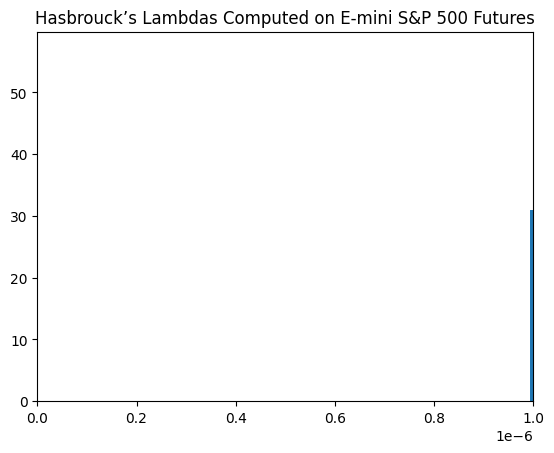

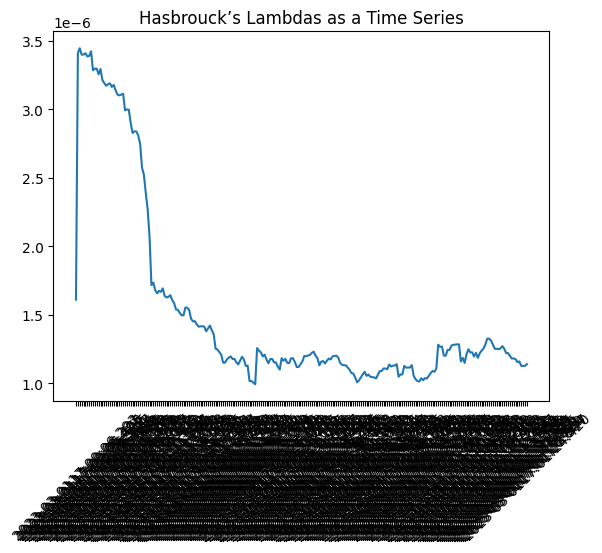

In [19]:
# Calculate hasbrouck lambda
hasbrouck_lambda = second_generation.get_bar_based_hasbrouck_lambda(tick_prices,
                                                             dollar_volumes,
                                                            tick_classifications,window=100)

plt.figure(1);
plt.hist(hasbrouck_lambda['hasbrouck_lambda'],bins=30);
plt.xlim(0,0.000001);
plt.title('Hasbrouck’s Lambdas Computed on E-mini S&P 500 Futures');
plt.figure(2);
plt.plot(hasbrouck_lambda['hasbrouck_lambda']);
plt.title('Hasbrouck’s Lambdas as a Time Series');
plt.xticks(rotation = 45);

The histogram above displays similar results for Figure 19.5 from de Prado's book. Inspecting both graphs and comparing them to Kyle's Amihud's we notice that there are some difference. The distribution of Hasbrouck's lambda is different with the most frequent values more centered. From the time series plot, the lambda's seem to be more consistent around certain periods (excoet for one outlier) which is a result of incorperating the Gibbs sampler.

## Conclusion

This notebook displayed the results from the second generation microstructural module. The notebook showcased how to implement these models and how to interpret and use the results. 

Key takeaways from the notebook:

* Kyle's Lambda can be interpreted as the cost of demanding a certain amount of liquidity over a given time period
* Amihud's Lambda computes the daily price response associated with one dollar of trading volume, and argues its value is a proxy of price impact. 
* Hasbrouck's Lambda involves estimating the price impact coefficient based on trade-and-quote (TAQ) data.

### Refrences

* de Prado, M.L., 2018. Advances in Financial Machine Learning.
* Kyle, A.S., 1985. Continuous auctions and insider trading. Econometrica: Journal of the Econometric Society, pp.1315-1335.
* Amihud, Y., 2002. Illiquidity and stock returns: cross-section and time-series effects. Journal of financial markets, 5(1), pp.31-56.
* Hasbrouck, J., 2009. Trading costs and returns for US equities: Estimating effective costs from daily data. The Journal of Finance, 64(3), pp.1445-1477.